# 第 7 章 利用AdaBoost元算法提高分类性能

**本章内容**
- 组合相似的分类器来提高分类性能
- 应用AdaBoost算法
- 处理非均衡分类问题

## 7.1 基于数据集多重抽样的分类器

我们可以通过**集成方法**（*ensemble method*）将不同的分类器组合起来，从而实现“三个臭皮匠顶个诸葛亮”的效果。

集成方法在使用时可以有多种形式：
- 不同算法的集成
- 同一算法在不同设置下的集成
- 数据集不同部分分配给不同分类器之后的集成

接下来，我们将介绍基于同一种分类器多个不同实例的两种计算方法。在这些方法当中，数据集也会不断变化，而后应用于不通的实例分类器上。最后，我们会讨论如何利用机器学习问题的通用框架来应用AdaBoost算法。

||AdaBoost|
|---|---|
|优点|泛化错误率低，易编码，可以应用在大部分分类器上，无参数调整。|
|缺点|对离群点敏感。|
|适用数据类型|数值型、标称型。|

### 7.1.1 bagging：基于数据随机重抽样的分类器构建方法

bagging方法，是从原始数据集选择S次后得到S个新数据集的一种技术。新数据集和原数据集的大小相等。每个数据集都是通过在原始数据集中随机选择一个样本来进行替换而得到的（有放回抽样）。

在S个数据集建好之后，将某个学习算法分别作用于每个数据集就得到了S个分类器。

当我们要对新数据进行分类时，就可以应用这S个分类器进行分类。与此同时，选择分类器投票结果中最多的类别作为最后的分类结果。

### 7.1.2 boosting

boosting是一种类似bagging的集成方法，不同之处在于boosting的分类器是通过串行训练而获得的，每个新分类器都根据已训练出的分类器的性能来进行训练。

此外关于权重的分配，bagging方法中各个分类器的权重是相等的，而boosting方法中各个分类器的权重并不相等，每个权重代表的是其对应分类器在上一轮迭代中的成功度。

boosting方法拥有多个版本，本章将只关注其中一个最流行的版本——AdaBoost。

|||AdaBoost的一般流程|
|---|---|---|
|(1)|收集数据：|可以使用任意方法。|
|(2)|准备数据：|依赖于所使用的弱分类器类型，本章使用的是单层决策树，这种分类器可以处理任何数据类型。当然也可以使用任意分类器作为弱分类器（如第2章到第6章中的任意分类器）。作为弱分类器，简单分类器的效果更好。|
|(3)|分析数据：|可以使用任意方法。|
|(4)|训练算法：|AdaBoost的大部分时间都用在训练上，分类器将多次在同一数据集上训练弱分类器。|
|(5)|测试算法：|计算分类的错误率。|
|(6)|使用算法：|同SVM一样，AdaBoost预测两个类别中的一个。如果想把它应用到多个类别的场合，那么就要像多类SVM中的做法一样对AdaBoost进行修改。|

下面我们将要讨论AdaBoost背后的一些理论，兵揭示其效果不错的原因。

## 7.2 训练算法：基于错误提升分类器的性能

AdaBoost的运行过程如下：

(1) 赋予数量为$n$的训练数据中每个样本一个相等的权重$D_i$（通常为$\frac{1}{n}$），这些权重构成向量$D$。

(2) 在训练集上训练出一个弱分类器并计算该分类器的错误率$\epsilon$。
$$
\epsilon = \frac{未正确分类的样本数量}{所有样本数量}
$$

(3) AdaBoost为每个分类器都分配了一个权重$\alpha$，其计算公式如下：
$$
\alpha = \frac{1}{2}ln(\frac{1-\epsilon}{\epsilon})
$$

(4) 根据$\alpha$调整每个样本的权重，降低第一次分对样本的权重，提高第一次分错样本的权重。具体而言：

对于被**正确**分类的样本，其权重更新为：

$$
D^{(t+1)}_i = \frac{D^{(t)}_ie^{-\alpha}}{Sum(D)}
$$

对于被**错误**分类的样本，其权重更新为：

$$
D^{(t+1)}_i = \frac{D^{(t)}_ie^{\alpha}}{Sum(D)}
$$

(5) 在相同数据集上利用调整好后的权重再次训练分类器。

(6) 重复步骤（3）和（5），直至训练错误率变为0或弱分类器数量达到预设值。

接下来，我们将建立完整的AdaBoost算法。在这之前，我们首先必须通过一些代码来建立弱分类器及保存数据集的权重。

## 7.3 基于单层决策树构建弱分类器

单层决策树（*decision stump*，也称决策桩）是一种简单的决策树，它仅基于单个特征来做决策。由于这棵树只有一次分裂过程，因此它实际上就是一个树桩。

接下来我们在构建AdaBoost的代码时，将首先通过一个简单数据集来确保在算法实现上一切就绪。

首先定义一个名为`loadSimpleData()`的函数用来生成简单数据集。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def loadSimpleData():
    datMat = np.matrix([[1.0, 2.1],
                        [2.0, 1.1],
                        [1.3, 1.0],
                        [1.0, 1.0],
                        [2.0, 1.0]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat, classLabels

然后定义一个`plotting`方法来画出简单数据集。

In [18]:
def plotting(data, labels) -> None:
    X1 = []
    Y1 = []
    X2 = []
    Y2 = []
    for i in range(data.shape[0]):
        if labels[i] == 1.0:
            X1.append(data[i, 0])
            Y1.append(data[i, 1])
        elif labels[i] == -1.0:
            X2.append(data[i, 0])
            Y2.append(data[i, 1])
        else:
            pass
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    ax.scatter(X1, Y1, marker='s', s=90)
    ax.scatter(X2, Y2, marker='o', s=50, c='red')
    plt.title('decision stump test data')
    plt.show()
    return

接下来导入数据集和标签，并将其画出。

In [17]:
datMat, classLabels = loadSimpleData()

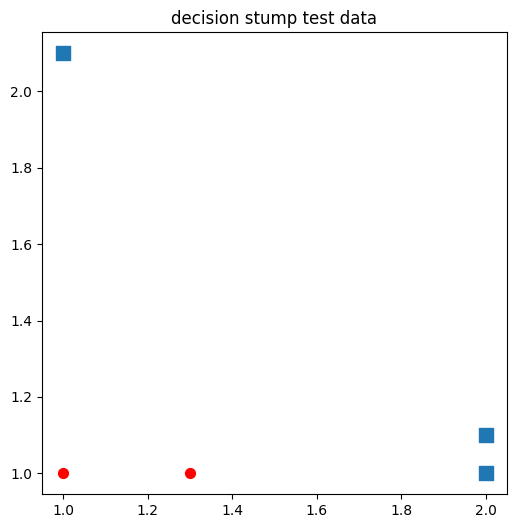

In [19]:
plotting(datMat, classLabels)

从上图中可以看出，如果想要试着从某个坐标轴上选择一个值（即选择一条与坐标轴平行的直线）来将所有的圆形点和方形点分开，这显然是不可能的。也就是说，单层决策树无法解决这一类的问题。但是通过使用多棵单层决策树我们就可以构建出一个能正确分类的分类器。

这个程序的伪代码大致如下：

（1）将最小错误率minError设为$\infty$

（2）对数据集中的每一个特征（第一层循环）：

        对每个步长（第二层循环）：
        
            对每个不等号（第三层循环）：
            
                建立一棵单层决策树并利用加权数据集对它进行测试
                
                如果错误率低于minError，则将当前单层决策树设为最佳单层决策树
                
（3）返回最佳单层决策树

接下来我们将通过两个函数来构建单层决策树。其中第一个函数(`stumpClassify()`）将用于测试是否有某个值小于或者大于我们正在测试的阈值。第二个函数（`buildStump()`）则更加复杂一些，它会在一个加权数据集中循环，并找到具有最低错误率的单层决策树。

In [22]:
def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):
    retArray = np.ones((np.shape(dataMatrix)[0], 1))
    if threshIneq == 'lt':    # less then
        retArray[dataMatrix[:, dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:, dimen] > threshVal] = -1.0
    return retArray

`stumpClassify()`函数通过阈值比较对数据进行分类。所有在阈值一边的数据会分到类别`-1`，而在另一边的数据会分到`+1`。这里的实现方式采用了数组过滤，首先将返回数组`retArray`的全部元素设为1，然后将所有不满足不等式要求的元素设为-1。

In [59]:
def buildStump(dataArr, classLabels, D):
    dataMatrix = np.asmatrix(dataArr)
    labelMat = np.asmatrix(classLabels).T
    m, n = np.shape(dataArr)
    numSteps = 10.0
    bestStump = {}
    bestClasEst = np.asmatrix(np.zeros((m, 1)))
    minError = np.inf

    for i in range(n):
        rangeMin = dataMatrix[:, i].min(); rangeMax = dataMatrix[:, i].max();
        stepSize = (rangeMax - rangeMin) / numSteps
        for j in range(-1, int(numSteps) + 1):
            for inequal in ['lt', 'gt']:
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)
                errArr = np.asmatrix(np.ones((m, 1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T * errArr
                print(f"split: dim {i}, thresh {threshVal:.2f}, thresh inequal: {inequal}, the weighted error is: {weightedError}")
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump, minError, bestClasEst

`buildStump()`会遍历`stumpClassify()`函数所有可能的输入值，并找到数据集上最佳的单层决策树。（这里的最佳是基于数据的权重向量`D`来定义的。）

`buildStump()`会先确保输入数据符合矩阵格式，然后定义了一个`bestStump`的字典，用于存储给定权重向量$D$时所得到的最佳单层决策树的相关信息。

In [61]:
D = np.asmatrix(np.ones((5,1))/5)
D

matrix([[0.2],
        [0.2],
        [0.2],
        [0.2],
        [0.2]])

In [62]:
bestStump, minError, bestClasEst = buildStump(datMat, classLabels, D)

split: dim 0, thresh 0.90, thresh inequal: lt, the weighted error is: [[0.4]]
split: dim 0, thresh 0.90, thresh inequal: gt, the weighted error is: [[0.6]]
split: dim 0, thresh 1.00, thresh inequal: lt, the weighted error is: [[0.4]]
split: dim 0, thresh 1.00, thresh inequal: gt, the weighted error is: [[0.6]]
split: dim 0, thresh 1.10, thresh inequal: lt, the weighted error is: [[0.4]]
split: dim 0, thresh 1.10, thresh inequal: gt, the weighted error is: [[0.6]]
split: dim 0, thresh 1.20, thresh inequal: lt, the weighted error is: [[0.4]]
split: dim 0, thresh 1.20, thresh inequal: gt, the weighted error is: [[0.6]]
split: dim 0, thresh 1.30, thresh inequal: lt, the weighted error is: [[0.2]]
split: dim 0, thresh 1.30, thresh inequal: gt, the weighted error is: [[0.8]]
split: dim 0, thresh 1.40, thresh inequal: lt, the weighted error is: [[0.2]]
split: dim 0, thresh 1.40, thresh inequal: gt, the weighted error is: [[0.8]]
split: dim 0, thresh 1.50, thresh inequal: lt, the weighted erro

上述单层决策树的生成函数是决策树的一个简化版本。它就是所谓的弱分类器，即弱分类算法。到现在为止，我们已经构建了单层决策树，并生成了程序，做好了过渡到完整AdaBoost算法的准备。

在下一节中，我们将使用多个弱分类器来构建AdaBoost代码。

## 7.4 完整AdaBoost算法的实现

在上一节中，我们构建了一个基于加权输入值进行决策的分类器。现在我们拥有了实现一个完整AdaBoost算法所需要的所有信息。接下来我们将利用7.3节构建的单层决策树来实现7.2节中的算法。整个过程的伪代码如下：

对每次迭代：
    
利用`buildStump()`函数找到最佳的单层决策树

将最佳单层决策树加入到单层决策树组

计算$\alpha$

计算新的权重向量$D$

更新累计类别估计值

如果错误率等于$0.0$，则退出循环

In [52]:
def adaBoostTrainDS(dataArr, classLabels, numIt=40):
    weakClassArr = []
    m = np.shape(dataArr)[0]
    D = np.asmatrix(np.ones((m, 1)) / m)
    aggClassEst = np.asmatrix(np.zeros((m, 1)))
    for i in range(numIt):
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)
        print(f"D: {D.T}")
        alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16)))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        print(f"classEst: {classEst.T}")
        expon = np.multiply(-1 * alpha * np.matrix(classLabels).T, classEst)
        D = np.multiply(D, np.exp(expon))
        D = D / D.sum()
        aggClassEst += alpha * classEst
        print(f"aggClassEst: {aggClassEst.T}")
        aggErrors = np.multiply(np.sign(aggClassEst) != np.asmatrix(classLabels).T, np.ones((m, 1)))
        errorRate = aggErrors.sum() / m
        print(f"total error: {errorRate}\n")
        if errorRate == 0.0: break
    return weakClassArr

我们定义了一个可以执行AdaBoost算法的函数：`adaBoostTrainDS()`，其中DS指的是单层决策树（decision stump），当然也可以用其他算法作为基分类器。

它的输入参数包括数据集dataArr，类别标签classLabels和迭代次数numIt，其中numIt是整个AdaBoost算法中唯一需要用户指定的参数。

它的输出则是一个单层决策树的数组。

接下来让我们运行一下这段函数，假定迭代次数为9。

In [60]:
classifierArray = adaBoostTrainDS(datMat, classLabels, 9)

split: dim 0, thresh 0.90, thresh inequal: lt, the weighted error is: [[0.4]]
split: dim 0, thresh 0.90, thresh inequal: gt, the weighted error is: [[0.6]]
split: dim 0, thresh 1.00, thresh inequal: lt, the weighted error is: [[0.4]]
split: dim 0, thresh 1.00, thresh inequal: gt, the weighted error is: [[0.6]]
split: dim 0, thresh 1.10, thresh inequal: lt, the weighted error is: [[0.4]]
split: dim 0, thresh 1.10, thresh inequal: gt, the weighted error is: [[0.6]]
split: dim 0, thresh 1.20, thresh inequal: lt, the weighted error is: [[0.4]]
split: dim 0, thresh 1.20, thresh inequal: gt, the weighted error is: [[0.6]]
split: dim 0, thresh 1.30, thresh inequal: lt, the weighted error is: [[0.2]]
split: dim 0, thresh 1.30, thresh inequal: gt, the weighted error is: [[0.8]]
split: dim 0, thresh 1.40, thresh inequal: lt, the weighted error is: [[0.2]]
split: dim 0, thresh 1.40, thresh inequal: gt, the weighted error is: [[0.8]]
split: dim 0, thresh 1.50, thresh inequal: lt, the weighted erro

C:\Users\wshengj\AppData\Local\Temp\ipykernel_26280\928259779.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16)))


根据`adaBoostTrainDS()`函数的定义，其返回值为一个包含所有弱分类器的数组，我们可以通过调用`classifierArray`变量来查看。

In [64]:
classifierArray

[{'dim': 0,
  'thresh': np.float64(1.3),
  'ineq': 'lt',
  'alpha': 0.6931471805599453},
 {'dim': 1,
  'thresh': np.float64(1.0),
  'ineq': 'lt',
  'alpha': 0.9729550745276565},
 {'dim': 0,
  'thresh': np.float64(0.9),
  'ineq': 'lt',
  'alpha': 0.8958797346140273}]

该数组包含三个字典，其中包含了分类所需要的所有信息。此时，一个分类器已经构建成功，接下来我们需要测试错误率来观察它的效果。

在下一节，我们将编写代码来实现测试功能。

## 7.5 测试算法：基于AdaBoost的分类

In [65]:
def adaClassify(datToClass, classifierArr):
    dataMatrix = np.asmatrix(datToClass)
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.asmatrix(np.zeros((m, 1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix,
                                 classifierArr[i]['dim'],
                                 classifierArr[i]['thresh'],
                                 classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha'] * classEst
        print(aggClassEst)
    return np.sign(aggClassEst)

In [66]:
adaClassify([0, 0], classifierArr)

NameError: name 'classifierArr' is not defined

## 7.6 示例：在一个难数据集上应用AdaBoost

本节我们将在第5章给出的马疝病数据集上应用AdaBoost分类器。

|||示例：在一个难数据集上的AdaBoost应用|
|---|---|:---|
|(1)|收集数据：|提供的文本文件。|
|(2)|准备数据：|确保类别标签是+1和-1而非1和0。|
|(3)|分析数据：|手工检查数据。|
|(4)|训练算法：|在数据上，利用`adaBoostTrainDS()`函数训练出一系列的分类器。|
|(5)|测试算法：|我们拥有两个数据集。在不采用随机抽样的方法下，我们就会对AdaBoost和Logistic回归的结果进行完全对等的比较。|
|(6)|使用算法：|观察该例子上的错误率。不过，也可以构建一个Web网站，让驯马师输入马的症状然后预测马是否会死去。|


## 7.7 非均衡分类问题

### 7.7.1 其他分类性能度量指标：正确率、召回率及ROC曲线

### 7.7.2 基于代价函数的分类器决策控制

### 7.7.3 处理非均衡问题的数据抽样方法